In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import math
from skimage import io
from skimage import transform as tf
import operator
import pytesseract
from PIL import Image
from PIL import Image, ImageEnhance 
from spellchecker import SpellChecker
from autocorrect import spell


In [2]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [3]:
image = cv2.imread('input4.jpg') #second argument specifies that imput is read in grayscale color space

image = image_resize(image,height=500);#reshaping the image


row,col = image.shape[:2]
bottom= image[row-2:row, 0:col]
    #mean= cv2.mean(bottom)[0]    

bordersize=60  #size of border
image=cv2.copyMakeBorder(image, top=0, bottom=0, left=50, right=0, borderType= cv2.BORDER_CONSTANT, value= [255,255,255])
cv2.imshow('input',image)
cv2.waitKey(0)
cv2.destroyWindow('input')

In [4]:




from scipy.misc import imread, imsave, imresize  #checking if image is in any other format or not

if(len(image.shape)<3):
      print ('gray')
elif len(image.shape)==3:
      print ('Color(RGB)')
else:
      print ('others')


Color(RGB)


In [5]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY);

In [6]:
(thresh1, im_bw1) = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)#without gaussian filter

blur = cv2.GaussianBlur(image,(1,1),0)#removing noice
(thresh2, im_bw2) = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)#with gaussian filter

blur = cv2.GaussianBlur(image,(7,7),0) #removing noise
th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,91,20)
th3 = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,2)

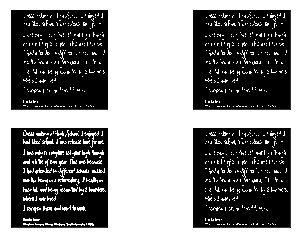

In [7]:
images = [im_bw1, im_bw2, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
   
    plt.xticks([]),plt.yticks([])
plt.show()

In [8]:
th2 = image_resize(th2,height=500);#reshaping the image
print(th2.shape)

(500, 487)


In [9]:
kernel = np.ones((2,2),np.uint8)
opening = cv2.morphologyEx(th2, cv2.MORPH_OPEN, kernel) #performing opening on the image to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(100,10))
erosion = cv2.dilate(opening,kernel,iterations = 1)  #thining the image

#kernel1 = np.ones((1,1),np.uint8)
#erosion = cv2.erode(erosion,kernel1,iterations = 10)
#edges = cv2.Canny(erosion,50,150)

In [10]:
def findSkew(processed_img):
    
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(processed_img > 0))
    angle = cv2.minAreaRect(coords)[-1]
 
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
    #otherwise take inverse of angle tp make it positive
    else:
        angle = -angle
   
    return angle
    
    

In [11]:
def deskew(angle,img):
     
    # rotate the image to deskew it
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    new_rotate = rotated.copy()
    # draw the correction angle on the image so we can validate it
    #cv2.putText(rotated, "Angle: {:.2f} degrees".format(angle),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2) #displaying text on image
 
    # show the output image
    print("[INFO] angle: {:.3f}".format(angle))
    cv2.imshow("Input", img)
    cv2.imshow("Rotated", rotated)
    cv2.waitKey(0)
    cv2.destroyWindow("Input")
    cv2.destroyWindow("Rotated")
    
    return rotated
    

In [12]:
angle = findSkew(erosion)
org_rot_img = deskew(angle,image)
proc_rot_img= deskew(angle,th2)

[INFO] angle: -0.000
[INFO] angle: -0.000


In [13]:
#kernel = np.ones((5,5), np.uint8)  #forming a kernal which spreads in horizontal direction...basically to join characters in a line
#img_dilation = cv2.erode(proc_rot_img, kernel, iterations=1)
#cv2.imshow('dilated',img_dilation)
#cv2.waitKey(0)
#cv2.destroyWindow('dilated')

In [14]:
#find contours
def findHandW(img):
    a=img.copy()
    kernel = np.ones((1,1), np.uint8) 
    img_erode = cv2.erode(img, kernel, iterations=1)
    kernel = np.ones((5,5), np.uint8)
    img_dilation = cv2.dilate(img_erode, kernel, iterations=2)
    im2,ctrs,heir = cv2.findContours(img_dilation.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_ctrs = sorted(ctrs, key=lambda ctrs: cv2.boundingRect(ctrs)[0])
    
    ctr = sorted_ctrs[0]
    x,y,w,h = cv2.boundingRect(ctr);
   # Getting ROI
    roi = a[y:y+h, x:x+w]

    # show ROI
    cv2.imshow('segment no:'+str(1),roi)
    
    cv2.rectangle(a,(x,y),( x + w, y + h ),(90,0,255),2)
    cv2.destroyWindow('segment no:'+str(1))

    #cv2.imshow('marked areas',a)
    #cv2.waitKey(0)
    #cv2.destroyWindow('marked areas')
    #print("height is",h)
    approx_char_width=0.5*h

In [15]:
os.chdir('C:\\Users\\ankur garg\\Documents\\projects\\handwritten2text') #changing the working directory to original


In [16]:
def slantAngCorr(slant_angle,crop_word):
   
    row,col = crop_word.shape[:2]
    bottom= crop_word[row-2:row, 0:col]
    #mean= cv2.mean(bottom)[0]    

    bordersize=60  #size of border
    border=cv2.copyMakeBorder(crop_word, top=10, bottom=bordersize, left=int((3*col)/2), right=10, borderType= cv2.BORDER_REPLICATE)
    # Create Afine transform
    afine_tf = tf.AffineTransform(shear=-slant_angle)   #to shear transform image opposite to the given angle
    #border = cv2.bitwise_not(border)                  #preprocessing to make the background black,same as sheared area color
    
    #border = cv2.cvtColor(border, cv2.COLOR_RGB2GRAY)
    
    #blur = cv2.GaussianBlur(border,(7,7),0) #removing noise
    #border = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV,91,20)
    
    # Apply transform to image data
    modified = tf.warp(border, inverse_map=afine_tf)     #transforming the image
    
    row,col = modified.shape[:2]
    
    modified=modified[0:row,int(col/2):col]
    # Display the result
    cv2.imshow('slant1',modified)
    cv2.imshow('slant2',border)
    cv2.waitKey(0)
    cv2.destroyWindow('slant1')
    cv2.destroyWindow('slant2')
    cv2.imwrite("word "+str(k)+".jpg",modified)
    return modified


In [17]:
def baseLineEstimation(slant_angle,color_word):
    
    color_word1=color_word.copy()
    h1,w1 = color_word.shape[:2]
    half_color_word = color_word[int(h1/2):h1,0:w1]
    
    h,w = color_word1.shape[:2]
    (ret, bin_word) = cv2.threshold(color_word1, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)  #converting to binary image
    #kernal = np.ones((5,10),np.uint8)
    #opening = cv2.morphologyEx(bin_word, cv2.MORPH_OPEN, kernel)
    hist = cv2.reduce(bin_word,1, cv2.REDUCE_AVG).reshape(-1)    #reducing 2d array to 1d in vertical direction

       
   # i = max(i for i,value in enumerate(hist) if value>15)    #finding the location in histogram where max number of pixel exist

   # desc = color_word[i:h,0:w]
    #crop_word = color_word1[0:i,0:w]
        
    #cv2.line(color_word1, (0,i), (w,i), (0,255,), 1)
    #cv2.imshow('line',color_word1)
    #cv2.waitKey(0)
    #cv2.destroyWindow('line')
    slant_corr = slantAngCorr(slant_angle,color_word1)  #correcting the slant angle of a word
    return slant_corr

In [18]:

def slant_angle_estimation(k,slant_angle,color_word):
    
    if k==0:   #for the first word 
        j=0    #as we will not be adding previous slant angle as it is the first word
    else:
        j=1    #we have 1 slant angle to be added already
    nop = 5 #number of parts
    
    h,w = color_word.shape[:2] #finding the height and width
    edges = cv2.Canny(color_word,50,150) # performing edge detection
    
    for i in range(nop):        #looping through number of parts into which the word will be divided
        
        new_sliced_word1 = color_word[0:h,int((i*w)/nop):int(((i+1)*w)/nop)]  #extracting the sliced word
        
        new_sliced_word = edges[0:h,int((i*w)/nop):int(((i+1)*w)/nop)]
        
        lines = cv2.HoughLines(new_sliced_word,1,np.pi/180,int(h/5),0,60)    # finding the best fit lines for the edges.The edges it will look at will be h/7         for rho,theta in lines[0]:
        if lines[0] is None:
            continue
            
        for rho,theta in lines[0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))  #finding the coordinates
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            new_sliced_word2=new_sliced_word1.copy()  #making a copy of sliced word
            #cv2.line(new_sliced_word1,(x1,y1),(x2,y2),(0,0,255),2)

        #cv2.imshow('line',new_sliced_word1)
        #cv2.waitKey(0)
        #cv2.destroyWindow('line')
        angle = math.atan2(y2-y1,x2-x1)  #find the slope of the detected line from the horizontal
        angle = math.degrees(angle)      #converting the angle to degree
        
        #print(angle)
        if angle<-50 and angle>-91 :  #checking if the angle lies between the given threshold values.
            
            slant_angle = slant_angle+angle   #we will take the mean of all the slant angle found in the word 
            j=j+1
    #print("slant angle new is",slant_angle)
    #print(j)
    
    if j==0:
        return (slant_angle/(j+1))    #returning slant angle. 1 is added to prevent division by zero
    else:
        return (slant_angle/j)

In [ ]:
def recChars(slant_corr,k):
    im = Image.open('word '+str(k)+'.jpg')
    enhancer = ImageEnhance.Contrast(im)
    enhanced_im = enhancer.enhance(4.0)
    #enhanced_im.show()
    pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
    text = pytesseract.image_to_string( im, config='--psm 8 ')
    punch=''
    
    l=len(text)
    if(text[l-1]=="." or text[l-1]==","):
        punch=text[l-1]
        text=text[0:l-1]
        
    spell = SpellChecker()
    word=text
    spell.word_frequency.remove('fo')
    if(word=="fo"):
        word="to"
    if(word=="1"):
        word="I"
    if word in spell:
        word=word+punch
        print(word,end =" ")
        
    else:
        cor=spell.correction(word)
        cor=cor+punch
        print(cor,end =" ")

In [ ]:
def findChars(slant_corr):
   
    
    new = slant_corr.copy()
    #new = cv2.bitwise_not(new)
    new = cv2.bitwise_not(new)
    new = np.uint8(new)
    
    #ret,new = cv2.threshold(new,200,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU) 
    th = 0
    H1,W1 = new.shape[:2]         #finding height and width of image
    #print("shape is",new.shape[:2] )
    #new = cv2.bitwise_not(new)
    new = np.uint8(new)   
    
    
    #findHandW(new)
    #W1=W1+100
    
    #kernel = np.ones((10,10),np.uint8)
    #new = cv2.morphologyEx(new, cv2.MORPH_CLOSE, kernel)
    #kernel = np.ones((10,10),np.uint8)
    #new = cv2.morphologyEx(new, cv2.MORPH_CLOSE, kernel)
    
    
    new, contours, hierarchy = cv2.findContours(new,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    slant_corr = cv2.drawContours(slant_corr, contours, -1, (0,255,0), 3)
    
    cv2.imshow('marked area',slant_corr)
    cv2.waitKey(0)
    cv2.destroyWindow('marked area')
    
    edges = cv2.Canny(new,50,50)
    #edges = cv2.resize(edges,(W1,H1));
    hist = cv2.reduce(slant_corr,0, cv2.REDUCE_AVG).reshape(-1)  
    
    seg1 = [x for x in range(W1-1) if hist[x]==0 and hist[x+1]>0]      #finding the left boundary of word
    seg2 = [x for x in range(W1-1) if hist[x]>0 and hist[x]>th and hist[x+1]<=th]     #finding the right boundary of wword

    
    for x in seg1:
        cv2.line(slant_corr, (x,0), (x,H1), (255,0,0), 1)

    for x in seg2:
        cv2.line(slant_corr, (x,0), (x,H1), (255,0,0), 1)
    

        
    cv2.imshow('marked area',slant_corr)
    cv2.waitKey(0)
    cv2.destroyWindow('marked area')

In [ ]:

def findWords(color_line,bw_line,k):                                    #function to segment lines to words
    
    os.chdir("..")
    kernel = np.ones((3,7), np.uint8)
    bw_line = cv2.dilate(bw_line, kernel, iterations=1)               #dilating image to join letters in a word
    kernel = np.ones((2,2),np.uint8)
    bw_line = cv2.morphologyEx(bw_line, cv2.MORPH_CLOSE, kernel)
    
    hist = cv2.reduce(bw_line,0, cv2.REDUCE_AVG).reshape(-1)            #reducing 2d image to id by taking average of pixels
   # hist1 = cv2.reduce(bw_line,0, cv2.REDUCE_AVG)
    #print(hist)
    #print(hist1)
    new = color_line.copy()
    th = 1
    H1,W1 = color_line.shape[:2]                                                #finding height and width of image
    lefts = [x for x in range(W1-1) if hist[x]<=th and hist[x+1]>th]      #finding the left boundary of word
    rights = [x for x in range(W1-1) if hist[x]>th and hist[x+1]<=th]     #finding the right boundary of wword

    
    for x in lefts:
        cv2.line(new, (x,0), (x,H1), (255,0,0), 1)

    for x in rights:
        cv2.line(new, (x,0), (x,H1), (0,255,0), 1)
    
    #print(lefts)
    #print(rights)
    cv2.imshow('marked area',new)
    cv2.waitKey(0)
    cv2.destroyWindow('marked area') 
    if len(lefts)!= len(rights):
            
        rights.append(W1-1)
        
        
        
    a = os.getcwd()
    os.chdir(a+'\extracted_words') #changing folder
    
    slant_angle = 0
    if len(lefts)!= 0:
        new_lefts=[lefts[0]]
    new_rights=[]
    
    word_num=[]
    arr=[]
    for l in range(len(lefts)-1):
        #print(l)
        arr.append(lefts[l+1]-rights[l])
        word_num.append(l)
    
    if len(arr)!=0:
        avg = sum(arr)/len(arr)
        avg = avg-(0.4*avg)
        per=((max(arr)-min(arr))/max(arr))*100
    
    
        #print(avg)
        #print("array is",arr)
        new_list=[]
    
        if(per>75):
            for l in range(len(lefts)-1):
                
                dist_bet_words=(lefts[l+1]-rights[l])
                if avg<dist_bet_words:
                    
                    new_lefts.append(lefts[l+1])
                    new_rights.append(rights[l])
            
            if len(rights)!=0:
                new_rights.append(rights[len(rights)-1])
        else:
            
            new_lefts=lefts
            new_rights=rights
            
    else:
        new_lefts=lefts
        new_rights=rights
        
    #print(new_lefts)
    #print(new_rights)
            
       
    
    
    for j in range(len(new_lefts)):
         
            
        if j!=0:
            norm_left = new_rights[j-1] #normalizing upper limit so that it remains little above the actual word so as not to lose information due to preprocessing
        else:
            norm_left = new_lefts[j]/4
        
        
        
        
        color_word = color_line[0:H1 , int((new_lefts[j]+norm_left)/2):new_rights[j]-1]  #extracting word from the colored line
        
        bw_word = bw_line[0:H1 , new_lefts[j]:new_rights[j]]   #extracting word from black and white line
    
       
        
        cv2.imshow('marked area',color_word)
        cv2.waitKey(0)
        cv2.destroyWindow('marked area')
        slant_angle = slant_angle_estimation(k,slant_angle,color_word) #finding th eslant angle of the word
        
        #print("slant angle is ",slant_angle)
        
        if slant_angle==0:    #if slant angle is 0, setting it to -90 as measurement is taken from horizontal
            slant_angle=-90
        slant_angle_new = -90-slant_angle   #as measuremnt is from horizontal, converting it with respect to vertical
        slant_angle_new = math.radians(slant_angle_new)   
        
        #slant_corr = baseLineEstimation(slant_angle_new,color_word)  #estimating the baseline
        cv2.imwrite("word "+str(k)+".jpg",color_word)
        #findChars(slant_corr)
        recChars(color_word,k)
        
        k=k+1
    
    os.chdir("..") #going back a folder 
    #print("slant angle is ",slant_angle)
    
    cv2.imshow('marked areas',new)
    cv2.waitKey(0)
    cv2.destroyWindow('marked areas')
    os.chdir(a+'\extracted_lines') #changing folder
    return k

In [ ]:
proc_rot_img2=proc_rot_img.copy()
cv2.imshow('marked areas',proc_rot_img2)
cv2.waitKey(0)
cv2.destroyWindow('marked areas')
kernel1 = np.ones((2,2), np.uint8)
proc_rot_img2 = cv2.erode(proc_rot_img2, kernel1, iterations=3)  #eroding the image
#cv2.imshow('marked areas',proc_rot_img2)
#cv2.waitKey(0)
#cv2.destroyWindow('marked areas')


kernel1 = np.ones((1,2), np.uint8)
proc_rot_img2 = cv2.dilate(proc_rot_img2, kernel1, iterations=1)   #dilating the image
cv2.imshow('marked areas',proc_rot_img2)
cv2.waitKey(0)
cv2.destroyWindow('marked areas')

hist = cv2.reduce(proc_rot_img2,1, cv2.REDUCE_AVG).reshape(-1)    #reducing the image to 1d
new = org_rot_img.copy()
th = 1
H,W = image.shape[:2]
uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]  #finding the upper boudary of line
lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]  #finding the lower boundary of line

#rotated = cv2.cvtColor(rotated, cv2.COLOR_GRAY2BGR)
for y in uppers:
    cv2.line(new, (0,y), (W, y), (255,0,0), 1)

for y in lowers:
    cv2.line(new, (0,y), (W, y), (255,255,255), 1)
    
#print(uppers)
#print(lowers)

a = os.getcwd()
os.chdir(a+'\extracted_lines') #changing folder
k=0


heights = []
for i in range(len(uppers)):
   
    
    if i!=0:
        norm_upper = lowers[i-1] #normalizing upper limit so that it remains little above the actual word so as not to lose information due to preprocessing
    else:
        norm_upper = uppers[i]/2
        
    if i<len(lowers)-1:
        norm_lower = uppers[i+1
                           
                           ] #normalizing upper limit so that it remains little above the actual word so as not to lose information due to preprocessing
    else:
        norm_lower = lowers[i]+lowers[i]/3
        
    color_line = org_rot_img[int((uppers[i]+norm_upper)/2):int((lowers[i]+norm_lower)/2), 0:W]  #extracting line from the colored image
    
    H1,W1 = color_line.shape[:2]
    
    heights.append(H1)
       
        
if len(heights)!=0:
        avg = sum(heights)/len(heights)
        avg = avg-(0.4*avg)
        per=((max(heights)-min(heights))/max(heights))*100






for i in range(len(uppers)):
   
    
    if i!=0:
        norm_upper = lowers[i-1] #normalizing upper limit so that it remains little above the actual word so as not to lose information due to preprocessing
    else:
        norm_upper = uppers[i]/2
        
    if i<len(lowers)-1:
        norm_lower = uppers[i+1
                           
                           ] #normalizing upper limit so that it remains little above the actual word so as not to lose information due to preprocessing
    else:
        norm_lower = lowers[i]+lowers[i]/3
        
    color_line = org_rot_img[int((uppers[i]+norm_upper)/2):int((lowers[i]+norm_lower)/2), 0:W]  #extracting line from the colored image
    
    bw_line = proc_rot_img2[uppers[i]:lowers[i], 0:W]   #extracting line from black and white image
    
    H1,W1 = color_line.shape[:2]
    
    if H1<avg:
        continue
    
    k = findWords(color_line,bw_line,k)             #calling function findwords to find the words in the line
    
    cv2.imwrite("line "+str(i)+".jpg",color_line)
    
os.chdir("..") #going back a folder
    

#cv2.imshow('marked areas',crop_img)
#cv2.waitKey(0)
#cv2.destroyWindow('marked areas')

Dress making at High School I enjoyed. I had liked school, 